In [1]:
#https://towardsdatascience.com/a-fresh-look-at-clustering-algorithms-c3c4caa1a691

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.backend='seaborn'
import time
import itertools

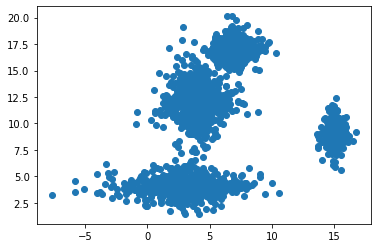

In [22]:
# Create the data
ttf=pd.DataFrame(
    {
        'x':np.concatenate(
            (
                3 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) * 3,
                15 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) / 2,
                7 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                4 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) * 1.5
            )
        ),
        'y':np.concatenate(
            (
                4 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                9 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                17 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000),
                12 + (
                    np.random.randint(-1, 1, 1000) * 2 + 1
                ) * np.random.exponential(scale=0.5, size=1000) * 2
            )
        )
    }
)
plt.scatter(ttf.x,ttf.y)
plt.show()

In [23]:
#normalise dataset
ttf_norm = ttf.copy()
ttf_norm['x'] = (
    ttf['x'] - np.min(ttf.x)
) / (
    np.max(ttf.x) - np.min(ttf.x)
)
ttf_norm['y'] = (
    ttf['y'] - np.min(ttf.y)
) / (
    np.max(ttf.y) - np.min(ttf.y)
)

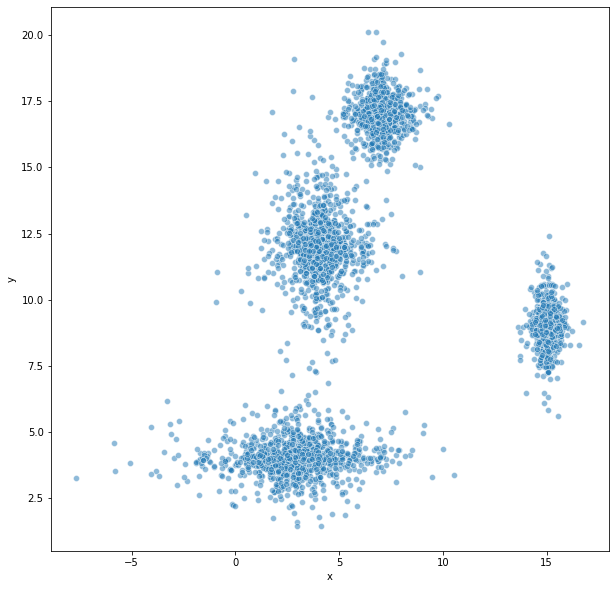

In [24]:
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5)

In [104]:
# count number of cells
D = int(np.sqrt(len(ttf_norm)))
tolerance = 90
X = ttf_norm[['x', 'y']].values
# SCale and discretise
Xint = (X * D).astype(int)

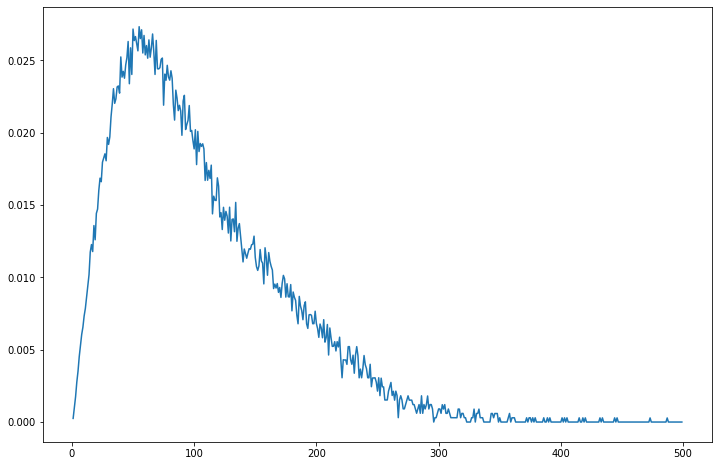

In [105]:
prop=[]
for d in range(1, 500):
    Xint = (X * d).astype(int)
    unique, counts = np.unique(Xint, axis=0, return_counts=True)
    prop.append(
        len(
            counts[counts > 10]
        )/(
            len(
                counts[counts == 1]
            ) + len(Xint) - len(unique)
        )
    )
    
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, 500)), prop)    
    

In [106]:
#copied code



def cell_cluster(Xint, D, tolerance=70):
    
    # Identify unique cells, with corresponding element counts
    unique, counts = np.unique(Xint, axis=0, return_counts=True)

    #calculate the threshold, corresponding to our tolerance
    mincount = int(
        np.percentile(
            counts[
                counts >1
            ],
            tolerance
        )
    )

  
    # reduce the array of elements to unique elements with counts over 
    # the threshold.
    allids = unique[counts > mincount]
    
    # run the function identifying the clusters of unit cells.
    clusters = find_trees(allids, D)
    
   
    return clusters
  

def find_trees(allids, D):
    # Function for counting unconnected trees.
    # Takes in the collection of identified cells above threshold (allids)
    # and the critical divisions parameter we defined at the start.
    # Returns a dictionary of clusters, with interger IDs as keys 
    # (assigned in order of passing trough)
    # and arrays of corresponding values
    
    
    len_ids=len(allids) #length of input array of elements, needed for status udates
    
    tocheck = np.array([]) # Array of neighbour ids set aside for checking
    
    clusters = dict() #output dictionary.
    clusterid = 0 # counter for identified clusters
    
    
    while len(allids) > 0:
        
        
        ids = allids[0]
        clusterid += 1
        allids = allids[1:]
        visited = ids # mark the current observation as visited
        
        # selecting nearest neighbours.
        # As we are dealing with integers in all dimensions
        # by design - setting the threshold to 1.
        # For some applications a higher number can be used here.
        mask = np.all(np.abs(allids-ids)<=1, axis=1)
        tch = allids[mask]
        allids = allids[~mask]
       
        if len(tch) > 0:
            
            tocheck = tch
            
            # Main loop - filling in the rest of the cluster
            
            while len(tocheck)>0:
                
                idsi = tocheck[0]
                tocheck = tocheck[1:]
                
                # mark as visited
                visited = np.vstack([visited, idsi])
                
                # get the neighbours
                mask = np.all(np.abs(allids-idsi)<=1, axis=1)
                nbrs = allids[mask]
                allids = allids[~mask]
                
                if len(nbrs) > 0:
                    tocheck = np.vstack([tocheck, nbrs])
                

                    
            # store all visited nodes into cluster dictionary.    
            clusters[clusterid] = visited   
           # clear_output(wait=True)
            print('Processed {:.2f}% ids'.format((len_ids-len(allids)) / len_ids * 100))
            print('{} clusters found'.format(len(clusters.keys())))       
    
    return clusters
  

def cluster_attribution(X, D, clusters):
    # For each element of X calculate the distance
    # to all identified cluster centroids
    # mark them with the id of nearest cluster.
    # technically only need to do this for unmarked
    # points, but we are doing it in vector form anyway,
    #so running through the entire X.
    yhat_ = np.sum(
                        (
                            X - np.average(
                                clusters[list(clusters.keys())[0]].astype(float),
                                axis=0
                            ) / D
                        ) ** 2,
                        axis=1
                )
    for i, k in enumerate(clusters.keys()):
        if i>0:
            yhat_ = np.vstack(
                [
                    yhat_,
                    np.sum(
                            (
                                X - np.average(
                                    clusters[k].astype(float),
                                    axis=0
                                ) / D
                            ) ** 2,
                            axis=1
                    )

                ]
            )
    yhat = np.argmin(yhat_.T, axis=1) + 1
    return yhat


def cluster_attribution_nearestneighbour(Xint, D, clusters):
    # Attributing points by finding the closest point
    # already assigned to a cluster. 
    
    #initiate the vector of outputs with zeros
    yhat = np.zeros(len(Xint))
    
    # iterate through clusters and mark up relevant points of yhat
    # result is cluster ids where identified and zeros where not
    for i, k in enumerate(clusters.keys()):
        yhat += (Xint[:, None] == clusters[k]).all(-1).any(-1) * k
    
    # calculate distances to all elements of all clusters and take min
    yhat_ = np.min(
                            np.sum(
                                (
                                    Xint[yhat == 0][:, None] - clusters[list(clusters.keys())[0]]
                                ) ** 2,
                                axis=-1
                            ),
                            axis=-1
                    )
    for i, k in enumerate(clusters.keys()):
        if i>0:
            yhat_ = np.vstack(
                [
                    yhat_,
                    np.min(
                            np.sum(
                                (
                                    Xint[yhat == 0][:, None] - clusters[k]
                                ) ** 2,
                                axis=-1
                            ),
                            axis=-1
                    )
                ]
            )
    # Mark up the unassigned elements of yhat
    yhat[yhat == 0] = np.take(
        np.array(
            list(clusters.keys())
        ),
        np.argmin(yhat_.T, axis=1).T
    )
    return yhat.astype(int)
 

def density_trees_fit(X, D, tolerance):
    # wrapper function - centroids
    Xint = (X * D).astype(int)
    clusters = cell_cluster(Xint, D, tolerance=tolerance)
    yhat = cluster_attribution(X, D, clusters)
    return yhat
  
def density_trees_fit_nn(X, D, tolerance):
  # wrapper function - nearest neighbour
    Xint = (X * D).astype(int)
    clusters = cell_cluster(Xint, D, tolerance=tolerance)
    yhat = cluster_attribution_nearestneighbour(Xint, D, clusters)
    return yhat

Processed 18.18% ids
1 clusters found
Processed 38.64% ids
2 clusters found
Processed 68.18% ids
3 clusters found
Processed 100.00% ids
4 clusters found


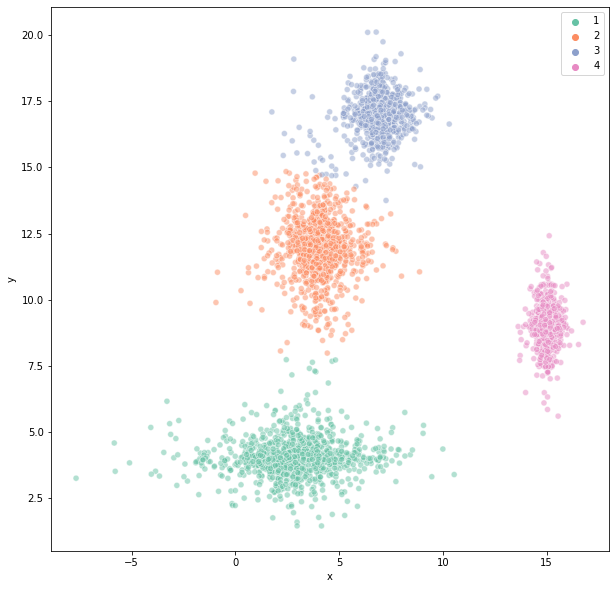

In [107]:
out = density_trees_fit(X,D,tolerance)
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5, hue = out,palette="Set2")


In [ ]:
##stop

In [99]:
#Create string ids for each cell:
Xstr = np.apply_along_axis(
        ''.join,
        1,
        np.char.zfill(
            Xint.astype(str),
            len(str(D))
        )
    )

In [32]:
# Create the dictionary with frequency of occurrence counts for all cells
unique, counts = np.unique(Xstr, return_counts=True)
tree = dict(zip(unique, counts))

In [56]:
# calculate threshold - percentile defined by tolerence
mincount = int(
        np.percentile(
            np.array(
                list(
                    tree.values()
                )
            )[
                np.array(
                    list(tree.values())
                ) >1
            ],
            tolerance
        )
    )

In [61]:
#Pruning the tree: get rid of everything below the mincount.
tree = {k: v for k, v in tree.items() if v > mincount}

In [65]:
# What’s happening here is — first we create all possible permutations 
# of -1, 0 and 1s in the horizontal dimension of X matrix 
# (in our case 2, as we only have 2 variables).

l = list(itertools.product([-1, 0, 1], repeat=Xint.shape[1]))
l=list(map(list, l))
l.remove([0] * Xint.shape[1])

In [87]:

tree

{'2108': 11,
 '2208': 17,
 '2309': 11,
 '2407': 15,
 '2408': 19,
 '2507': 17,
 '2508': 18,
 '2509': 11,
 '2607': 18,
 '2608': 22,
 '2707': 23,
 '2708': 24,
 '2709': 21,
 '2735': 12,
 '2808': 26,
 '2809': 17,
 '2832': 11,
 '2833': 11,
 '2834': 14,
 '2835': 17,
 '2836': 12,
 '2907': 11,
 '2908': 20,
 '2909': 14,
 '2933': 16,
 '2934': 20,
 '2935': 32,
 '2936': 19,
 '2937': 14,
 '2939': 11,
 '3008': 26,
 '3031': 12,
 '3032': 15,
 '3033': 22,
 '3034': 26,
 '3035': 19,
 '3036': 25,
 '3037': 19,
 '3039': 12,
 '3133': 11,
 '3134': 18,
 '3135': 19,
 '3136': 14,
 '3138': 11,
 '3236': 11,
 '3335': 11,
 '3551': 13,
 '3552': 16,
 '3650': 18,
 '3651': 25,
 '3652': 30,
 '3653': 24,
 '3654': 11,
 '3749': 15,
 '3750': 32,
 '3751': 52,
 '3752': 72,
 '3753': 48,
 '3754': 20,
 '3755': 18,
 '3756': 12,
 '3849': 12,
 '3850': 29,
 '3851': 53,
 '3852': 71,
 '3853': 28,
 '3854': 16,
 '3950': 12,
 '3951': 17,
 '3952': 32,
 '3953': 13,
 '3954': 11,
 '4052': 13,
 '4053': 11,
 '5723': 14,
 '5724': 32,
 '5725': 49,

In [67]:
lD = len(str(D))
ids = tree
nbrs = np.array(
            [
                list(
                    [
                        int(
                            ''.join(
                                list(ids)[i * lD: (i + 1) * lD]
                            )
                        ) for i in range(len(l[0]))
                    ]
                )
            ] * len(l)
        ) + np.array(l)

In [68]:
nbrs

array([[21082207, 23092406],
       [21082207, 23092407],
       [21082207, 23092408],
       [21082208, 23092406],
       [21082208, 23092408],
       [21082209, 23092406],
       [21082209, 23092407],
       [21082209, 23092408]])

In [69]:
nbrs = np.apply_along_axis(
            ''.join,
            1,
            np.char.zfill(
                nbrs.astype(str),
                lD
            )
        )

In [84]:
import sklearn
from sklearn.cluster import AffinityPropagation
model = AffinityPropagation(damping=0.9)
model.fit(X)
ttf_norm['Affinity'] = model.predict(X)

In [85]:
ttf_norm


,x,y,Affinity
0,0.403613,0.054289,2
1,0.499547,0.117719,5
2,0.610836,0.135909,7
3,0.240559,0.131216,4
4,0.465935,0.123485,5
...,...,...,...
3995,0.450356,0.405691,19
3996,0.480408,0.522116,18
3997,0.461608,0.798855,21
3998,0.468782,0.505873,18


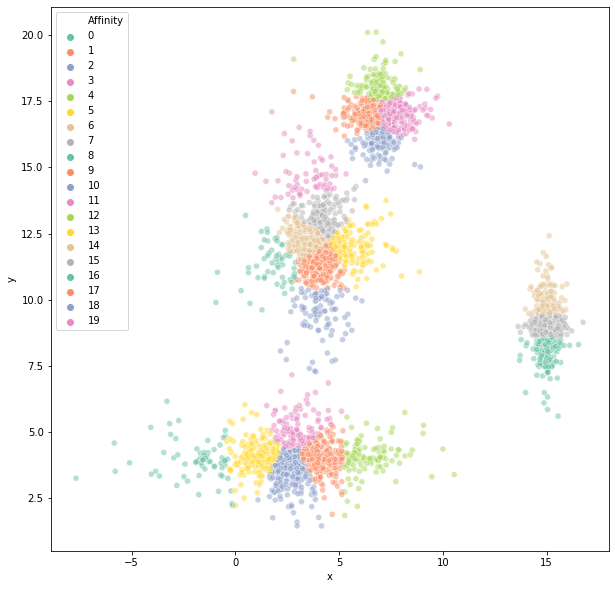

In [81]:
plt.figure(figsize=(10, 10))
sns.scatterplot(ttf.x, ttf.y, alpha=0.5, hue = ttf_norm.Affinity,palette="Set2")

Processed 33.33% ids
1 clusters found
Processed 59.52% ids
2 clusters found
Processed 84.29% ids
3 clusters found
Processed 100.00% ids
4 clusters found


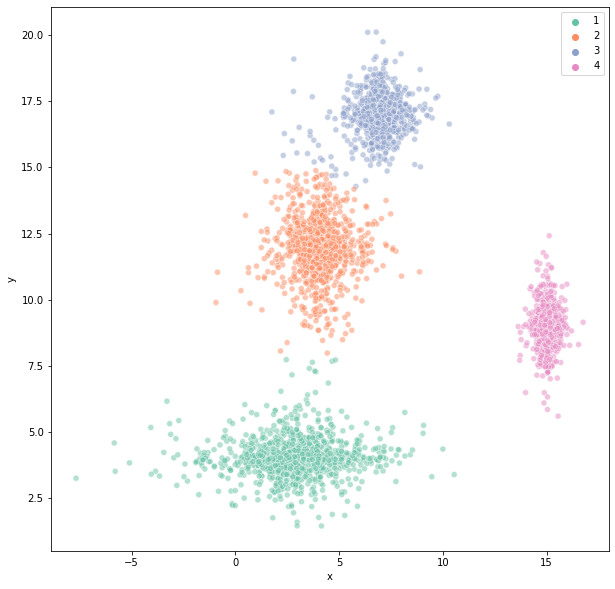